In [2]:
import sys
sys.path.insert(0, '../../../PyPlr')

import numpy as np
import pandas as pd

from pyplr.CIE import get_CIES026
from pyplr.oceanops import predict_dark_spds, calibrated_radiance

# Spectral sensitivities

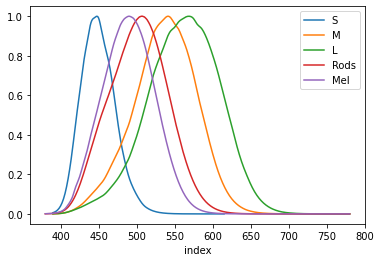

In [3]:
_ , sss = get_CIES026(asdf=True)
#sss = sss[::5] # downsample to 5nm bins
sss.plot()
sss = sss.fillna(0)

# Get calibrated radiance data

In [ ]:
# Gather some functions
oo_spectra = pd.read_csv('../data/oo_led_intensity_spectra_08-17-20-14-31.csv')
oo_info = pd.read_csv('../data/oo_led_intensity_info_08-17-20-14-31.csv')

oo_info.rename({'intensitiy':'intensity'}, inplace=True)
oo_dark_spds = predict_dark_spds(oo_info, '../data/oo_dark_cal.txt')
cal_per_wl = pd.read_csv('../data/oo_calibration.csv', header=None)
sensor_area_cm2 = pd.read_csv('../data/oo_sensorArea.csv', header=None)

# Call function
wperm2pernm = calibrated_radiance(oo_spectra, oo_info, oo_dark_spds, cal_per_wl, sensor_area_cm2)

# Replace indices
wperm2pernm['led'] = oo_info['led']
wperm2pernm['intensity'] = oo_info['intensity']
wperm2pernm.set_index(['led', 'intensity'], inplace=True)
wperm2pernm.sort_index(inplace=True)
wperm2pernm.columns = sss.index

In [4]:
alphaopicradiance = wperm2pernm.dot(sss)
alphaopicradiance.to_csv('../data/')

,S,M,L,Rods,Mel
intensity,,,,,
0,5.175408e-16,8.661721e-12,1.645815e-11,1.329549e-12,2.486165e-13
65,7.797343e-08,6.113556e-09,4.331393e-09,2.145632e-08,2.726898e-08
130,2.338864e-07,2.182920e-08,1.722237e-08,6.729973e-08,8.443649e-08
195,4.493756e-07,4.645608e-08,3.834226e-08,1.333790e-07,1.658290e-07
260,8.781542e-07,9.465240e-08,7.945900e-08,2.641586e-07,3.272250e-07
...,...,...,...,...,...
3835,8.768719e-06,9.921709e-07,8.281657e-07,2.733142e-06,3.364853e-06
3900,8.863557e-06,1.001131e-06,8.348329e-07,2.761658e-06,3.400507e-06
3965,8.988150e-06,1.012160e-06,8.429127e-07,2.799149e-06,3.447670e-06


In [5]:
# Take 0-1 and turn it into 4095
x = np.random.rand(1, 2)
np.round(x*4095)

array([[1660., 1625.]])

In [7]:
def interp_spectra(spectra):
    '''
    This function needs generalising.

    Parameters
    ----------
    spectra : TYPE
        DESCRIPTION.

    Returns
    -------
    intp_tbl : TYPE
        DESCRIPTION.

    '''
    #tbl = spectra.unstack(level=0)
    #tbl.columns = [val[1] for val in tbl.columns]
    
    intp_tbl = pd.DataFrame()
    for led, df in spectra.groupby(['led']):
        intensities = df.index.get_level_values('intensity')
        new_intensities = np.linspace(intensities.min(), intensities.max(), 4096)
        new_intensities = new_intensities.astype('int')
        df.reset_index(inplace=True, drop=True)
        df.columns = range(0, df.shape[1])
        df.index = df.index * 63
        n = df.reindex(new_intensities).interpolate(method='linear')
        n['intensity'] = n.index
        n['led'] = led
        intp_tbl = intp_tbl.append(n)
    intp_tbl.set_index(['led','intensity'], inplace=True)
    return intp_tbl

In [8]:
#alphaopicradiance.set_index(['led','intensity'], inplace=True)
d = 1000*interp_spectra(alphaopicradiance)
d.columns = sss.columns
d

S             M             L          Rods  \
led intensity                                                           
0   0          5.175408e-13  8.661721e-09  1.645815e-08  1.329549e-09   
    1          1.237674e-06  1.055648e-07  8.494917e-08  3.418849e-07   
    2          2.475348e-06  2.024679e-07  1.534402e-07  6.824402e-07   
    3          3.713021e-06  2.993710e-07  2.219312e-07  1.022996e-06   
    4          4.950695e-06  3.962741e-07  2.904222e-07  1.363551e-06   
...                     ...           ...           ...           ...   
9   4091       2.630495e-04  6.309178e-04  3.179113e-03  3.441684e-04   
    4092       2.630495e-04  6.309178e-04  3.179113e-03  3.441684e-04   
    4093       2.630495e-04  6.309178e-04  3.179113e-03  3.441684e-04   
    4094       2.630495e-04  6.309178e-04  3.179113e-03  3.441684e-04   
    4095       2.630495e-04  6.309178e-04  3.179113e-03  3.441684e-04   

                        Mel  
led intensity                
0   0          2.486165e-10  
    1          4.330857e-07  
    2          8.659228e-07  
    3          1.298760e-06  
    4          1.731597e-06  
...                     ...  
9   4091       3.153099e-04  
    4092       3.153099e-04  
    4093       3.153099e-04  
    4094       3.153099e-04  
    4095       3.153099e-04  

[40960 rows x 5 columns]

In [9]:
def smlri_calculator(x, d):
    """
    x is 20 values, between 0 and 1
    Takes 20 values, corresponding to the values for the primaries in two scenarios. Scenario 1: low-mel, scenario: high-mel.
    x[0:9] -> low-mel
    x[10:19] -> high-mel
    """
    settings1 = x[0:9]
    settings2 = x[10:19]
    smlr1 = 0
    smlr2 = 0
    for ii in range(0, 9):
        idx1 = int(np.round(settings1[ii] * 4095))
        idx2 = int(np.round(settings2[ii] * 4095))
        smlr1 = smlr1 + d.loc[(ii, idx1)]
        smlr2 = smlr2 + d.loc[(ii, idx2)]
    return smlr1, smlr2

In [10]:
def melanopsin_contrast_calculator(x, d):
    smlr1, smlr2 = smlri_calculator(x, d)
    contrast = 1-pow((smlr2.Mel-smlr1.Mel)/smlr1.Mel, 2)
    return contrast

In [11]:
def cone_contrast_calculator(x, d):
    smlr1, smlr2 = smlri_calculator(x, d)
    contrast = np.array([(smlr2.S-smlr1.S)/smlr1.S, (smlr2.M-smlr1.M)/smlr1.M, (smlr2.L-smlr1.L)/smlr1.L])
    return contrast

In [ ]:
# Random start
x0 = np.random.rand(1, 20)[0]
from scipy.optimize import minimize

from scipy.optimize import Bounds
# Set up the bounds
bounds = Bounds(np.ones((20))*0, np.ones((20))*1)

cons = {'type': 'eq',
       'fun': lambda x, d: pow(cone_contrast_calculator(x, d), 2),
       'args': (d,)
       }

es = minimize(melanopsin_contrast_calculator, x0, method='trust-constr', args=d, constraints=cons, options={'verbose': 1, 'maxiter' : 5000}, bounds=bounds)

KeyboardInterrupt: 

In [14]:
#melanopsin_contrast_calculator(es.x, d), cone_contrast_calculator(es.x, d)


(-0.0004183014800037471, array([0.05171784, 0.02871645, 0.03869218]))